In [155]:
import gensim.downloader as api
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
from sklearn.decomposition import PCA

import numpy as np
import pickle
import json
import copy
import pandas as pd
from tqdm import tqdm
import scipy.stats as stats
from sklearn.metrics.pairwise import cosine_similarity
from collections import defaultdict 

from Vocab import Vocab
vocab = Vocab('data/vocab.csv', 3)
from get_predictions import get_predictions
from helpers import *

from ChainDataset import ChainDataset

chain_test_set = ChainDataset(
    data_dir='data/',
    segment_file='segments.json',
    chain_file='test_chains.json',
    vectors_file='vectors.json',
    split='test'
)



[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/emmahokken/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Initialising vocab from file.


In [156]:
wv_google_300d = api.load('word2vec-google-news-300')
wv_twitter_50d = api.load('glove-twitter-50')


## Cosine similarity

In [5]:
dataset_pred_no_hist, dataset_pred_hist_cp, conditions_inds, condition_seg_hist, dataframe = get_pred_datasets_orig()

loaded model: No history
Initialising vocab from file.
vocab len 3424
Initialising vocab from file.
Loaded seg2ranks and idlist
params. normalize=True, mask=True, weight=5.5, weighting=True, batchsize=1, breaking=False
Dataparams. data_dir=./data, segmentfile=segments.json, vectorfile=vectors.json, chains_file=chains.json
segment dataset with segments.json vectors.json test
history dataset with test_segments.json vectors.json test_chains.json test
processing test

Start prediction
predict no history
{'segment': [5, 212, 4, 166, 5, 12, 22, 782, 29, 234, 213, 10, 4, 416, 14, 12, 22, 7, 6, 49, 11, 6, 155, 295, 11, 6, 811, 16, 9, 95, 10, 5, 17, 8, 12], 'image_set': ['93469', '380128', '14238', '259745', '524866', '341060', '483794', '96757'], 'targets': [5], 'length': 35, 'preds': tensor([[[0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.]]]), 'loss': tensor(4.9204), 'ranks': [0]}
getting predicitons took 41.8447539806366 seconds
l

  0%|          | 0/6801 [00:00<?, ?it/s]

[4, 12, 22, 7, 21, 11, 294, 16, 9, 945, 10, 5, 13, 8, 12, 31] [4, 12, 22, 7, 21, 11, 294, 16, 9, 945, 10, 5, 13, 8, 12, 31]
No history
History


100%|██████████| 6801/6801 [00:00<00:00, 45468.83it/s]


In [6]:
stopword_list = stopwords.words('english')

stopword_list.append("-B-")
stopword_list.append("-A-")
stopword_list.append("<unk>")

stemmer = nltk.stem.porter.PorterStemmer()


In [157]:
def embed(seg):
    embedding = np.zeros((300,))
    length = 0
    for word in seg:

        # only use word if it is not a stopword 
        if word in stopword_list:
            continue
            
        # try to embed word and add it to sentence vector 
        try:
            em = wv_google_300d[word]
            embedding += em
            length += 1
        except KeyError:
            continue
    
    return embedding / length 

def get_cosim(condition, condition_seg_hist):
    cosine_sim = []
    csh_keys = list(condition_seg_hist[condition])
    count = 0 

    for k in csh_keys:
        
        # ensure current chain is not empty (TODO: fix this maybe? so this doesn't happen)
        if condition_seg_hist[condition][k] == {}:
            continue
            
        # decode first and current sentence 
        first_seg = list(condition_seg_hist[condition][k].values())[0]['first_seg']
        current_seg = list(condition_seg_hist[condition][k].values())[0]['current_seg']
        dec_first_seg = vocab.decode(first_seg)
        dec_current_seg = vocab.decode(current_seg)
        
        # embed words  
        embed_first = embed(dec_first_seg).reshape(1, -1)
        embed_current = embed(dec_current_seg).reshape(1, -1)
        
        # calculate cosine similarity 
        try: 
            cosim = cosine_similarity(embed_first, embed_current)
            cosine_sim.append(cosim)
        except ValueError:
            count += 1
            
    print(count)
    
    # calculate mean and std 
    cosine_sim = np.array(cosine_sim)
    cosine_sim_mean = cosine_sim.mean()
    cosine_sim_std = cosine_sim.std()
    
    return cosine_sim, cosine_sim_mean, cosine_sim_std

def sort_into_ranks(condition, condition_seg_hist):
    ranks = defaultdict(list)
    
    csh_keys = list(condition_seg_hist[condition])

    for k in csh_keys:
        
        # ensure current chain is not empty (TODO: fix this maybe? so this doesn't happen)
        if condition_seg_hist[condition][k] == {}:
            continue
            
        rank = list(condition_seg_hist[condition][k].values())[0]['round']
        ranks[str(rank)].append(list(condition_seg_hist[condition][k].values())[0])
    return ranks

def cosine_ranks(rank_dict):
    count = 0
    cosine_sim = []
    for rank in rank_dict:

        # ensure current chain is not empty (TODO: fix this maybe? so this doesn't happen)
        if rank == {}:
            continue
            
        # decode first and current sentence 
        first_seg = rank['first_seg']
        current_seg = rank['current_seg']
        dec_first_seg = vocab.decode(first_seg)
        dec_current_seg = vocab.decode(current_seg)
        
        # embed words  
        embed_first = embed(dec_first_seg).reshape(1, -1)
        embed_current = embed(dec_current_seg).reshape(1, -1)
        
        # calculate cosine similarity 
        try: 
            cosim = cosine_similarity(embed_first, embed_current)
            cosine_sim.append(cosim)
        except ValueError:
            count += 1
                
    # calculate mean and std 
    cosine_sim = np.array(cosine_sim).squeeze()
    cosine_sim_mean = cosine_sim.mean()
    cosine_sim_std = cosine_sim.std()
    
    return cosine_sim, cosine_sim_mean, cosine_sim_std

In [158]:
cosim_hT_nhF, cosim_hT_nhF_mean, cosim_hT_nhF_std = get_cosim('hT_nhF', condition_seg_hist)
cosim_hT_nhT, cosim_hT_nhT_mean, cosim_hT_nhT_std = get_cosim('hT_nhT', condition_seg_hist)
cosim_hF_nhF, cosim_hF_nhF_mean, cosim_hF_nhF_std = get_cosim('hF_nhF', condition_seg_hist)
cosim_hF_nhT, cosim_hF_nhT_mean, cosim_hF_nhT_std = get_cosim('hF_nhT', condition_seg_hist)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide


3


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide


7
0
0


In [159]:
# Statistical analysis

# Reshape samples
cosim_hT_nhF, cosim_hT_nhT, cosim_hF_nhF, cosim_hF_nhT = cosim_hT_nhF.squeeze(), cosim_hT_nhT.squeeze(), cosim_hF_nhF.squeeze(), cosim_hF_nhT.squeeze()

print('Test if equal variance')
print(stats.levene(cosim_hT_nhF, cosim_hT_nhT, cosim_hF_nhF, cosim_hF_nhT))
print()

print('Test if normally distributed')
print('cosim_hT_nhF:', stats.normaltest(cosim_hT_nhF))
print('cosim_hT_nhT:', stats.normaltest(cosim_hT_nhT))
print('cosim_hF_nhF:', stats.normaltest(cosim_hF_nhF))
print('cosim_hF_nhT:', stats.normaltest(cosim_hF_nhT))
print()

print('Test if samples differ significantly using ANOVA')
print(stats.f_oneway(cosim_hT_nhF, cosim_hT_nhT, cosim_hF_nhF, cosim_hF_nhT))
print()

print('If any of the above tests were significant, perform Kruskal test')
print(stats.kruskal(cosim_hT_nhF, cosim_hT_nhT, cosim_hF_nhF, cosim_hF_nhT))



Test if equal variance
LeveneResult(statistic=7.396300268467312, pvalue=6.442093796887582e-05)

Test if normally distributed
cosim_hT_nhF: NormaltestResult(statistic=15.639719370397831, pvalue=0.00040167804022368965)
cosim_hT_nhT: NormaltestResult(statistic=181.5790640456814, pvalue=3.7205507072854045e-40)
cosim_hF_nhF: NormaltestResult(statistic=24.96104875725523, pvalue=3.799943428317518e-06)
cosim_hF_nhT: NormaltestResult(statistic=33.99154238638241, pvalue=4.1574817846862625e-08)

Test if samples differ significantly using ANOVA
F_onewayResult(statistic=15.070543498766023, pvalue=1.1664044423475807e-09)

If any of the above tests were significant, perform Kruskal test
KruskalResult(statistic=30.55123533852024, pvalue=1.056606151723308e-06)


In [149]:
print(stats.ttest_ind(cosim_hT_nhF, cosim_hT_nhT))
print(stats.ttest_ind(cosim_hT_nhF, cosim_hF_nhT))
print(stats.ttest_ind(cosim_hT_nhF, cosim_hF_nhF))
print()

print(stats.ttest_ind(cosim_hF_nhF, cosim_hT_nhT))
print(stats.ttest_ind(cosim_hF_nhF, cosim_hF_nhT))
print(stats.ttest_ind(cosim_hF_nhF, cosim_hT_nhF))
print()

print(stats.ttest_ind(cosim_hT_nhT, cosim_hT_nhF))
print(stats.ttest_ind(cosim_hT_nhT, cosim_hF_nhT))
print(stats.ttest_ind(cosim_hT_nhT, cosim_hF_nhF))
print()

print(stats.ttest_ind(cosim_hF_nhT, cosim_hT_nhT))
print(stats.ttest_ind(cosim_hF_nhT, cosim_hT_nhF))
print(stats.ttest_ind(cosim_hF_nhT, cosim_hF_nhF))
print()


Ttest_indResult(statistic=-3.1229277801384825, pvalue=0.0018328941248359942)
Ttest_indResult(statistic=-1.4651372940432967, pvalue=0.14512562898697645)
Ttest_indResult(statistic=1.1685342999712363, pvalue=0.24378550374480962)

Ttest_indResult(statistic=-6.329648827582439, pvalue=3.384408573625465e-10)
Ttest_indResult(statistic=-2.484939783102449, pvalue=0.01372733953540725)
Ttest_indResult(statistic=-1.1685342999712363, pvalue=0.24378550374480962)

Ttest_indResult(statistic=3.1229277801384825, pvalue=0.0018328941248359942)
Ttest_indResult(statistic=0.5879802759925874, pvalue=0.5566565345647296)
Ttest_indResult(statistic=6.329648827582439, pvalue=3.384408573625465e-10)

Ttest_indResult(statistic=-0.5879802759925874, pvalue=0.5566565345647296)
Ttest_indResult(statistic=1.4651372940432967, pvalue=0.14512562898697645)
Ttest_indResult(statistic=2.484939783102449, pvalue=0.01372733953540725)



In [160]:
sorted_hT_nhF = sort_into_ranks('hT_nhF', condition_seg_hist)
sorted_hT_nhT = sort_into_ranks('hT_nhT', condition_seg_hist)
sorted_hF_nhF = sort_into_ranks('hF_nhF', condition_seg_hist)
sorted_hF_nhT = sort_into_ranks('hF_nhT', condition_seg_hist)

all_data = {'hT_nhT': {'2': [], '3': [], '4': [], '5': []}, 
        'hT_nhF': {'2': [], '3': [], '4': [], '5': []}, 
        'hF_nhT': {'2': [], '3': [], '4': [], '5': []}, 
        'hF_nhF': {'2': [], '3': [], '4': [], '5': []}}
all_mean = {'hT_nhT': [], 
        'hT_nhF': [], 
        'hF_nhT': [], 
        'hF_nhF': []}
all_std = {'hT_nhT': [], 
        'hT_nhF': [], 
        'hF_nhT': [], 
        'hF_nhF': []}

conditions = ['hT_nhT', 'hT_nhF', 'hF_nhT', 'hF_nhF']

# Create workable dictionary 
for i, cond in enumerate([sorted_hT_nhF, sorted_hT_nhT, sorted_hF_nhF, sorted_hF_nhT]):
    key = conditions[i]
    for r in [2, 3, 4, 5]:   
        cosim = cosine_ranks(cond[str(r)])
        all_data[key][str(r)].append(cosim[0])
        all_mean[key].append(cosim[1])
        all_std[key].append(cosim[2])

# Perform t-test
print('hT_nhT')
print(stats.ttest_ind(all_data['hT_nhT']['2'][0], all_data[cond]['4'][0]))
print('hT_nhF')
print(stats.ttest_ind(all_data['hT_nhF']['2'][0], all_data[cond]['5'][0]))
print('hF_nhT')
print(stats.ttest_ind(all_data['hF_nhT']['2'][0], all_data[cond]['4'][0]))
print('hF_nhF')
print(stats.ttest_ind(all_data['hF_nhF']['2'][0], all_data[cond]['3'][0]))

print()


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:100: RuntimeWarning: Mean of empty slice.
/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide
/

hT_nhT


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:100: RuntimeWarning: Mean of empty slice.
/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:100: RuntimeWarning: Mean of empty slice.
/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtyp

TypeError: unhashable type: 'collections.defaultdict'

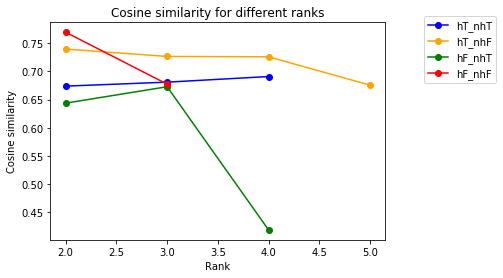

In [151]:
import matplotlib.pyplot as plt 

colors = ['blue', 'orange', 'green', 'red', 'purple']
x_range = list(range(2,6))
plot_conds = ['hT_nhT', 'hT_nhF','hF_nhT','hF_nhF']

for i, condition in enumerate(plot_conds):
    mean_vals = np.array(all_mean[condition])
    std_vals = np.array(all_std[condition])
    plt.plot(x_range, mean_vals, marker='o', label=condition, color=colors[i])
#     plt.fill_between(x_range, mean_vals-std_vals, mean_vals+std_vals,
#                     color=colors[i], alpha=.2)
    
    
plt.title("Cosine similarity for different ranks")
plt.ylabel('Cosine similarity')
plt.xlabel('Rank')
plt.legend()
plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.show()   
    

In [125]:
stats.ttest_ind(all_data['hT_nhF']['2'], all_data['hT_nhF']['4'])

/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3367: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:130: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


ValueError: operands could not be broadcast together with shapes (401,) (30,) 